# Setup

### Types of input

In [2]:
inputs = ["clean", "stem", "lemma", "lemma_stem"]

## Import Annotated Data

In [3]:
import pandas as pd
import numpy as np
import nltk

In [4]:
annotated = pd.read_pickle('in_between_files/prepared_annotation.pkl')
clean_annotated = list(annotated["clean_tweet_all_texts"])
stem_annotated = list(annotated["stemmed_all_texts"])
lemma_annotated = list(annotated["lemmatized_all_texts"])
lemma_stem_annotated = list(annotated["lemmatize_stem_all_texts"])

datasets = {"clean":clean_annotated, 
            "stem": stem_annotated, 
            "lemma": lemma_annotated, 
            "lemma_stem":lemma_stem_annotated
           }
y = np.array(list(annotated["Encode"]))
N = len(clean_annotated)

## Construct stop words

### Just run this

In [5]:
import pickle
stop_words_dict = pickle.load(open("stop_words_dict.pkl", "rb"))

### Construct Stop Words

In [7]:
from spacy.lang.en.stop_words import STOP_WORDS as spacy_stop_words
from nltk.corpus import stopwords as nltk_stop_words
import string
base_stop_words = [] 
base_stop_words += nltk_stop_words.words("english")
base_stop_words += spacy_stop_words

In [8]:
contractions_file = open('contractions.txt', 'r')
contractions = contractions_file.readlines()
contractions_file.close()
contractions = [contr.replace("\n","") for contr in contractions]
base_stop_words += contractions
base_stop_words.sort()

In [9]:
from Script_Processing.stem_and_lemmatize import StemLemmaWrapper
sl_wrapper = StemLemmaWrapper()
stem_stop = [sl_wrapper.stem(x) for x in base_stop_words]
lemma_stop = [sl_wrapper.lemmatize(x) for x in base_stop_words]
lemma_stem_stop = [sl_wrapper.stem(x) for x in lemma_stop]

In [10]:
stop_words_dict = {"clean":base_stop_words, 
            "stem": stem_stop, 
            "lemma": lemma_stop, 
            "lemma_stem":lemma_stem_stop
           }

In [11]:
import pickle
pickle.dump(stop_words_dict, open("stop_words_dict.pkl", "wb"))

# Build Pipeline

In [7]:
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier

In [8]:
universal_random_state = 42
n_cores = 1

In [9]:
classifiers = [(RidgeClassifier(), "ridgeclf"),
        (Perceptron(random_state = universal_random_state), "pcpt"),
        (KNeighborsClassifier(n_jobs=n_cores), "knn"),
        (RandomForestClassifier(random_state = universal_random_state, n_jobs=n_cores), "rfc"),
        (LinearSVC(random_state = universal_random_state, max_iter=5000), "linsvm"),
        (SGDClassifier(loss='hinge', penalty='l2', n_jobs=n_cores, random_state = universal_random_state), "gdsvm"),
        (SGDClassifier(loss='log', n_jobs=n_cores, random_state = universal_random_state), "gdlr"),
        (LogisticRegression(random_state = universal_random_state, n_jobs=n_cores, max_iter=5000), "lr"),
        (MultinomialNB(), "mnb"),
        (ComplementNB(), "cnb"),
        (BernoulliNB(), "bnb"),
        (DecisionTreeClassifier(random_state = universal_random_state),"dectree"),
        (MLPClassifier(random_state = universal_random_state), "neuralnet")
       ]

### Some comments on the classifiers, courtesy sk-learn documentation (a lot copy-pasted!):
- ```RidgeClassifier```: Linear Regression with Ridge Penalty
    - alpha, float, default=1.0; Regularization strength; must be a positive float. Regularization improves the conditioning of the problem and reduces the variance of the estimates.
- ```Perceptron```: Linear classification method, can be thought of as subcase of SVM.
    - penalty, {‘l2’,’l1’,’elasticnet’}, default=None; The penalty (aka regularization term) to be used.
    - alpha, float, default=0.0001; Constant that multiplies the regularization term if regularization is used
    - random_state, int, RandomState instance, default=None; Used to shuffle the training data, when shuffle is set to True. Pass an int for reproducible output across multiple function calls. See Glossary.
- ```KNeighborsClassifier```: Find the k-nearest neighbors of a sample and have them vote on the classification
    - n_neighbors, int, default=5; Number of neighbors to use by default for kneighbors queries.
    - weights, {‘uniform’, ‘distance’} or callable, default=’uniform’; weight function used in prediction. Possible values:
        - ‘uniform’ : uniform weights. All points in each neighborhood are weighted equally.
        - ‘distance’ : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.
        - callable : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.
    - leaf_size, int, default=30; Leaf size passed to BallTree or KDTree. This can affect the speed of the construction and query, as well as the memory required to store the tree. The optimal value depends on the nature of the problem.
- ```RandomForestClassifier```: A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.
    - max_depth, int, default=None; The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
    - ccp_alpha, non-negative float, default=0.0; Complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen. By default, no pruning is performed. See Minimal Cost-Complexity Pruning for details.
    - oob_score, bool, default=False; Whether to use out-of-bag samples to estimate the generalization accuracy.
- ```LinearSVC```: Support Vector Machine with linear kernel (which seems to be best for text data)
    - penalty, {‘l1’, ‘l2’}, default=’l2’; Specifies the norm used in the penalization. The ‘l2’ penalty is the standard used in SVC. The ‘l1’ leads to coef_ vectors that are sparse.
    - loss{‘hinge’, ‘squared_hinge’}, default=’squared_hinge’; Specifies the loss function. ‘hinge’ is the standard SVM loss (used e.g. by the SVC class) while ‘squared_hinge’ is the square of the hinge loss.
    - C, float, default=1.0; Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive.
- ```SGDClassifier(loss='hinge', penalty='l2')```: Implementation of SVM using stochastic gradient descent. Loss = 'hinge' and penalty = 'l2' give you a linear SVM.
    - alpha, float, default=0.0001; Constant that multiplies the regularization term. The higher the value, the stronger the regularization. Also used to compute the learning rate when set to learning_rate is set to ‘optimal’.
- ```SGDClassifier(loss='log')```: Implementation of Logistic Regression using stochastic gradient descent. Loss = 'log' gives you a logistic regression.
    - alpha, float, default=0.0001; Constant that multiplies the regularization term. The higher the value, the stronger the regularization. Also used to compute the learning rate when set to learning_rate is set to ‘optimal’.
    - penalty, {‘l2’, ‘l1’, ‘elasticnet’}, default=’l2’; The penalty (aka regularization term) to be used. Defaults to ‘l2’ which is the standard regularizer for linear SVM models. ‘l1’ and ‘elasticnet’ might bring sparsity to the model (feature selection) not achievable with ‘l2’.
- ```LogisticRegression```: Logistic Regression
    - penalty, {‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’; Used to specify the norm used in the penalization. The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties. ‘elasticnet’ is only supported by the ‘saga’ solver. If ‘none’ (not supported by the liblinear solver), no regularization is applied.
    - C, float, default=1.0; Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
- ```MultinomialNB```: Variation of Naive Bayes algorithm, well suited to text data. The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.
    - alpha, float, default=1.0; Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing).
- ```ComplementNB```: Variation of Naive Bayes algorithm, well suited to text data. It is particularly suited for imbalanced data sets.
    - alpha, float, default=1.0; Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing).
- ```BernoulliNB```: Variation of Naive Bayes algorithm, well suited to text data. BernoulliNB is designed for binary/boolean features, and will binarize features.
    - alpha, float, default=1.0; Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing).
- ```DecisionTreeClassifier```: A decision tree classifier, where the top deciding features are turned into nodes for a decision tree. Very interpretable, called a "white-box" model.
    - max_depth, int, default=None; The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
    - ccp_alpha, non-negative float, default=0.0; Complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen. By default, no pruning is performed. See Minimal Cost-Complexity Pruning for details.

In [34]:
full_name = {}
full_name["ridgeclf"] = "Ridge Classifier"
full_name["pcpt"] = "Perceptron"
full_name["knn"] = "K-Nearest Neighbors"
full_name["rfc"] = "Random Forest Classifier"
full_name["linsvm"] = "Linear SVM"
full_name["gdsvm"] = "Gradient Descent SVM"
full_name["gdlr"] = "Gradient Descent Logistic Regression"
full_name["lr"] = "Logistic Regression"
full_name["mnb"] = "Multinomial Naive Bayes"
full_name["cnb"] = "Complement Naive Bayes"
full_name["bnb"] = "Bernoulli Naive Bayes"
full_name["dectree"] = "Decision Tree"
full_name["neuralnet"] = "MLP Classifier (Neural Net)"

In [11]:
hyper_params = {}
hyper_params["ridgeclf"] = {'alpha': [0.01,1.0]}
hyper_params["pcpt"] = {'penalty': ["l2","l1","elasticnet", None
                                   ], 'alpha': [0.0001, 0.0005, 0.001, 0.01, 0.1, 1.0]}
hyper_params["knn"] = {'n_neighbors': [5,10,15], 'leaf_size': [20,30,40], 'weights':['uniform', 'distance']}
hyper_params["rfc"] = {'max_depth': [2,3,4,5, None], 'ccp_alpha':[0.0, 0.01, 0.1, 0.5], 'oob_score': [True, False]}
hyper_params["linsvm"] = {'C':[0.5, 1,2,5,10,100], 'loss': ["hinge", "squared_hinge"], 'penalty':['l1', 'l2']}
hyper_params["gdsvm"] = {'alpha': [0.0001,0.0005, 0.001, 0.01, 0.1, 1]}
hyper_params["gdlr"] = {'alpha': [0.0001,0.0005, 0.001, 0.01, 0.1, 1], 'penalty': ['l2', 'l1', 'elasticnet']}
hyper_params["lr"] = {'C':[0.5, 1.0,2,5,10,100], 'penalty': ['l2','l1','elasticnet', 'none']}
hyper_params["mnb"] = {'alpha' : [0.01, 0.05, 0.1, 1.0, 2.0]}
hyper_params["cnb"] = {'alpha' : [0.01, 0.05, 0.1, 1.0, 2.0]}
hyper_params["bnb"] = {'alpha' : [0.01, 0.05, 0.1, 1.0, 2.0]}
hyper_params["dectree"] = {'max_depth': [2,3,4,5, None], 'ccp_alpha':[0.0, 0.01, 0.1, 0.5]}
hyper_params["neuralnet"] = {}

In [12]:
dummy_params = {}
dummy_params["ridgeclf"] = {'alpha': [0.01]}
dummy_params["pcpt"] = {'penalty': ["l2"], 'alpha': [0.0001]}
dummy_params["knn"] = {'n_neighbors': [5], 'leaf_size': [30], 'weights':['uniform']}
dummy_params["rfc"] = {'max_depth': [2], 'ccp_alpha':[0.0, 0.01], 'oob_score': [True, False]}
dummy_params["linsvm"] = {'C':[1], 'loss': ["hinge"], 'penalty':['l2']}
dummy_params["gdsvm"] = {'alpha': [0.0001]}
dummy_params["gdlr"] = {'alpha': [0.0001], 'penalty': ['l2']}
dummy_params["lr"] = {'C':[1.0], 'penalty': ['l2', 'none']}
dummy_params["mnb"] = {'alpha' : [0.01]}
dummy_params["cnb"] = {'alpha' : [0.01]}
dummy_params["bnb"] = {'alpha' : [0.01]}
dummy_params["dectree"] = {'max_depth': [2], 'ccp_alpha':[0.0, 0.01]}
dummy_params["neuralnet"] = {}

In [164]:
scoring_metrics = ['accuracy', 'balanced_accuracy', 
                   'average_precision', 'f1_weighted', 
                   'precision', 'recall',
                   'jaccard','roc_auc']

target_names = ["unrelated", "related"]

# Initialize Vectorizers
Three kinds:
- Count Vectorizer (BOW)
- tf-idf Vectorizer
- Word2Vec representation

In [14]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV

In [15]:
vectorizer = TfidfVectorizer(sublinear_tf=True, max_features = 50, max_df=0.15, min_df = 0.01,
                                 stop_words=stop_words_dict["lemma_stem"])

In [16]:
X = vectorizer.fit_transform(np.array(datasets["lemma_stem"]))

/Users/nutangupta/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ai', 'am', 'clock', 'da', 'dare', 'day', 'er', 'gim', 'giv', 'gon', 'na', 'ne', 'need', 'ought', 'sha', 'shall', 'ta', 'wan', 'wo', 'ye'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=universal_random_state)

In [18]:
def print_metrics(gs, scoring_metrics):
    for metric in scoring_metrics:
        means = gs.cv_results_['mean_test_' + metric]
        stds = gs.cv_results_['std_test_' + metric]
        best_param = gs.best_params_
        for mean, std, params in zip(means, stds, gs.cv_results_['params']):
            if params == best_param:
                print(metric+":","%0.3f (+/-%0.03f) for %r"
                      % (mean, std * 2, params))

In [19]:
import time

In [20]:
def process_classifier(clf, name, hyperparams):
    start = time.time()
    print("-"*10, "Processing {}".format(full_name[name]), "-"*10)
    gs = GridSearchCV(clf, param_grid = hyperparams[name], 
                      scoring = scoring_metrics, cv = 5, refit = 'f1_weighted')
    gs.fit(X_train, y_train)
    duration = time.time() - start
    if duration > 60:
        print(full_name[name], "completed in {:.2f} minutes.".format(duration/60),"\n\n")
    else:
        print(full_name[name], "completed in {:.2f} seconds.".format(duration),"\n\n")
            
    print_metrics(gs, scoring_metrics)
    print("\n")
    
    return gs.best_estimator_, name

In [21]:
def plot_learning_curve(name, train_sizes, train_scores, test_scores):
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        # Plot learning curve
        plt.title(name)
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1,
                             color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1,
                             color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                     label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                     label="Cross-validation score")
        plt.legend(loc="best")
        
        plt.show()



In [22]:
import eli5
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

/Users/nutangupta/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/nutangupta/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [23]:
def study_tuned_classifier(clf, name):
    train_sizes, train_scores, test_scores = learning_curve(clf, X, y, cv=5)
    plot_learning_curve(name, train_sizes, train_scores, test_scores)
    clf.fit(X_train, y_train)
    if hasattr(clf, 'coef_'):
        explanation = eli5.explain_weights(clf, vec = vectorizer, top = (500,500))
        print(eli5.formatters.text.format_as_text(explanation))

In [28]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score


In [111]:
def evaluate_clf_on_heldout_data(clf, name, X_test, y_test):
    print("-"*10, "Evaluate on held-out data, {}".format(full_name[name]), "-"*10)
    pred = clf.predict(X_test)
    print(classification_report(y_test, pred, target_names=target_names))
    if hasattr(clf, 'decision_function'):
        y_score = clf.decision_function(X_test)
    elif hasattr(clf, 'predict_proba'):
        y_score = clf.predict_proba(X_test)[1]
        return
    else:
        return
    print("ROC AUC Score:\t\t", roc_auc_score(y_test, y_score, average='weighted'),'\n\n')

In [30]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=universal_random_state, shuffle=True)

In [31]:
def cross_validate_voting_clf(clf, X, y):
    accuracies = []
    for train_index, test_index in skf.split(X, y):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train,y_train)
        accuracies.append(accuracy_score(clf.predict(X_test), y_test))
      
    return sum(accuracies) / 5

# Main Pipeline

Why do we get warnings? Because some of the parameter configurations are so bad they only predict all of one class! That's leading to some metrics being ill-defined

In [32]:
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

In [35]:
tuned_classifiers = [process_classifier(clf, name, hyper_params) for clf, name in classifiers]

---------- Processing Ridge Classifier ----------
Ridge Classifier completed in 0.17 seconds. 


accuracy: 0.817 (+/-0.029) for {'alpha': 0.01}
balanced_accuracy: 0.789 (+/-0.029) for {'alpha': 0.01}
average_precision: 0.821 (+/-0.029) for {'alpha': 0.01}
f1_weighted: 0.814 (+/-0.028) for {'alpha': 0.01}
precision: 0.782 (+/-0.070) for {'alpha': 0.01}
recall: 0.689 (+/-0.057) for {'alpha': 0.01}
jaccard: 0.577 (+/-0.048) for {'alpha': 0.01}
roc_auc: 0.872 (+/-0.025) for {'alpha': 0.01}


---------- Processing Perceptron ----------
Perceptron completed in 1.44 seconds. 


accuracy: 0.762 (+/-0.049) for {'alpha': 0.0005, 'penalty': 'l1'}
balanced_accuracy: 0.732 (+/-0.064) for {'alpha': 0.0005, 'penalty': 'l1'}
average_precision: 0.624 (+/-0.109) for {'alpha': 0.0005, 'penalty': 'l1'}
f1_weighted: 0.758 (+/-0.051) for {'alpha': 0.0005, 'penalty': 'l1'}
precision: 0.695 (+/-0.087) for {'alpha': 0.0005, 'penalty': 'l1'}
recall: 0.620 (+/-0.155) for {'alpha': 0.0005, 'penalty': 'l1'}
jaccar

In [112]:
for clf, name in tuned_classifiers:
    print(evaluate_clf_on_heldout_data(clf, name, X_test, y_test))
    

---------- Evaluate on held-out data, Ridge Classifier ----------
              precision    recall  f1-score   support

     related       0.88      0.70      0.78       315
   unrelated       0.59      0.82      0.69       165

    accuracy                           0.74       480
   macro avg       0.73      0.76      0.73       480
weighted avg       0.78      0.74      0.75       480

ROC AUC Score:		 0.8489754689754689 


None
---------- Evaluate on held-out data, Perceptron ----------
              precision    recall  f1-score   support

     related       0.74      0.90      0.81       315
   unrelated       0.67      0.41      0.51       165

    accuracy                           0.73       480
   macro avg       0.71      0.65      0.66       480
weighted avg       0.72      0.73      0.71       480

ROC AUC Score:		 0.7048965848965848 


None
---------- Evaluate on held-out data, K-Nearest Neighbors ----------
              precision    recall  f1-score   support

     rel

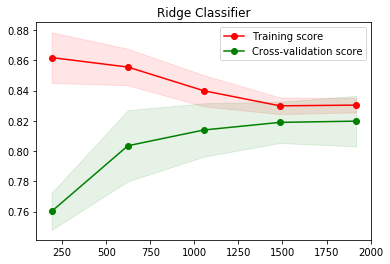

Explained as: linear model

Features with largest coefficients.
Caveats:
1. Be careful with features which are not
   independent - weights don't show their importance.
2. If scale of input features is different then scale of coefficients
   will also be different, making direct comparison between coefficient values
   incorrect.
3. Depending on regularization, rare features sometimes may have high
   coefficients; this doesn't mean they contribute much to the
   classification result for most examples.

y=1 top features
Weight  Feature   
------  ----------
+1.476  warmer    
+1.390  humid     
+1.378  kill      
+1.320  hot       
+1.223  away      
+1.071  temperatur
+1.066  april     
+1.053  spread    
+0.927  trump     
+0.830  cold      
+0.804  case      
+0.754  virus     
+0.588  summer    
+0.553  death     
+0.548  stop      
+0.523  find      
+0.441  covid19   
+0.438  test      
+0.410  high      
+0.404  know      
+0.378  outbreak  
+0.373  think     
+0.323  come     

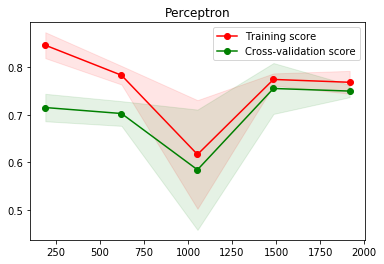

Explained as: linear model

Features with largest coefficients.
Caveats:
1. Be careful with features which are not
   independent - weights don't show their importance.
2. If scale of input features is different then scale of coefficients
   will also be different, making direct comparison between coefficient values
   incorrect.
3. Depending on regularization, rare features sometimes may have high
   coefficients; this doesn't mean they contribute much to the
   classification result for most examples.

y=1 top features
Weight  Feature   
------  ----------
+0.555  stop      
+0.398  spread    
+0.148  trump     
+0.042  kill      
+0.040  temperatur
+0.030  case      
-0.070  <BIAS>    
-0.148  forecast  
-0.277  plan      
-0.372  bad       
-0.849  work      



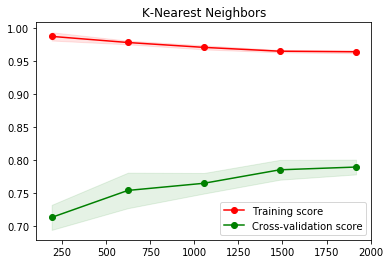

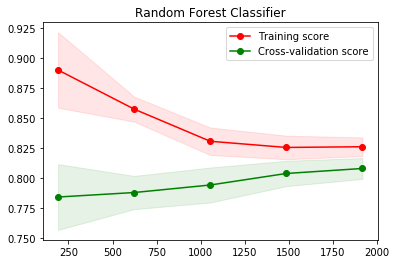

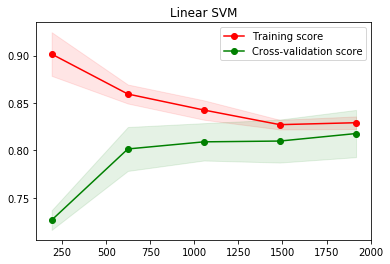

Explained as: linear model

Features with largest coefficients.
Caveats:
1. Be careful with features which are not
   independent - weights don't show their importance.
2. If scale of input features is different then scale of coefficients
   will also be different, making direct comparison between coefficient values
   incorrect.
3. Depending on regularization, rare features sometimes may have high
   coefficients; this doesn't mean they contribute much to the
   classification result for most examples.

y=1 top features
Weight  Feature   
------  ----------
+3.537  humid     
+3.062  warmer    
+2.950  hot       
+2.863  kill      
+2.654  away      
+2.439  temperatur
+2.093  april     
+2.070  spread    
+2.020  trump     
+1.741  virus     
+1.524  cold      
+1.422  case      
+1.103  summer    
+1.068  find      
+1.063  death     
+0.894  test      
+0.863  know      
+0.861  covid19   
+0.861  stop      
+0.861  think     
+0.860  outbreak  
+0.858  high      
+0.637  report   

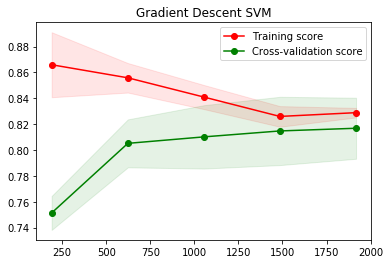

Explained as: linear model

Features with largest coefficients.
Caveats:
1. Be careful with features which are not
   independent - weights don't show their importance.
2. If scale of input features is different then scale of coefficients
   will also be different, making direct comparison between coefficient values
   incorrect.
3. Depending on regularization, rare features sometimes may have high
   coefficients; this doesn't mean they contribute much to the
   classification result for most examples.

y=1 top features
Weight  Feature   
------  ----------
+2.928  humid     
+2.747  warmer    
+2.604  hot       
+2.544  kill      
+2.392  away      
+2.116  temperatur
+1.831  spread    
+1.814  april     
+1.764  trump     
+1.549  virus     
+1.349  cold      
+1.226  case      
+0.939  summer    
+0.838  find      
+0.806  death     
+0.646  covid19   
+0.627  stop      
+0.620  test      
+0.587  know      
+0.543  think     
+0.534  outbreak  
+0.511  high      
+0.482  report   

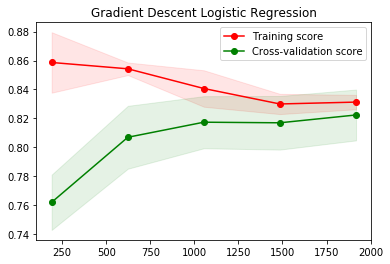

Explained as: linear model

Features with largest coefficients.
Caveats:
1. Be careful with features which are not
   independent - weights don't show their importance.
2. If scale of input features is different then scale of coefficients
   will also be different, making direct comparison between coefficient values
   incorrect.
3. Depending on regularization, rare features sometimes may have high
   coefficients; this doesn't mean they contribute much to the
   classification result for most examples.

y=1 top features
Weight  Feature   
------  ----------
+3.312  warmer    
+3.165  humid     
+3.109  kill      
+3.071  hot       
+2.626  away      
+2.578  temperatur
+2.447  spread    
+2.358  april     
+2.137  trump     
+2.013  virus     
+1.790  case      
+1.754  cold      
+1.259  summer    
+1.254  stop      
+1.232  death     
+1.175  find      
+1.051  test      
+1.004  high      
+0.936  covid19   
+0.890  know      
+0.847  outbreak  
+0.734  think     
+0.652  come     

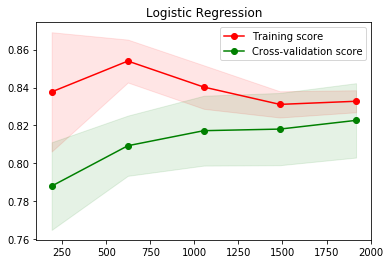

Explained as: linear model

Features with largest coefficients.
Caveats:
1. Be careful with features which are not
   independent - weights don't show their importance.
2. If scale of input features is different then scale of coefficients
   will also be different, making direct comparison between coefficient values
   incorrect.
3. Depending on regularization, rare features sometimes may have high
   coefficients; this doesn't mean they contribute much to the
   classification result for most examples.

y=1 top features
Weight  Feature   
------  ----------
+3.346  warmer    
+3.168  kill      
+3.162  hot       
+3.078  humid     
+2.680  away      
+2.571  spread    
+2.551  temperatur
+2.426  april     
+2.252  trump     
+2.081  virus     
+1.913  cold      
+1.889  case      
+1.411  summer    
+1.381  stop      
+1.299  death     
+1.250  find      
+1.131  high      
+1.124  test      
+1.096  covid19   
+0.973  know      
+0.927  outbreak  
+0.902  think     
+0.774  come     

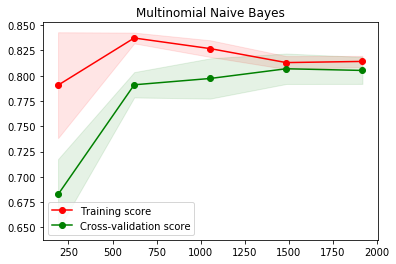

Error: estimator MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True) is not supported


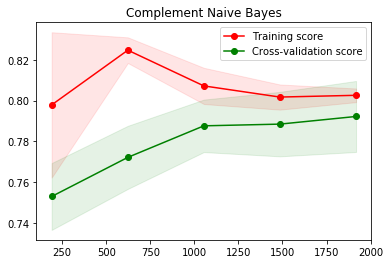

Error: estimator ComplementNB(alpha=2.0, class_prior=None, fit_prior=True, norm=False) is not supported


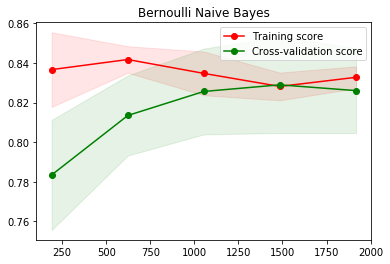

Error: estimator BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True) is not supported


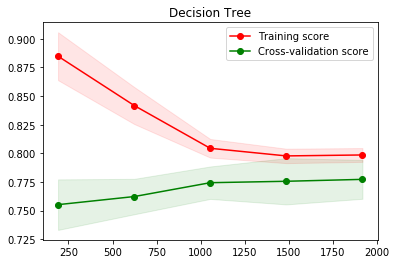

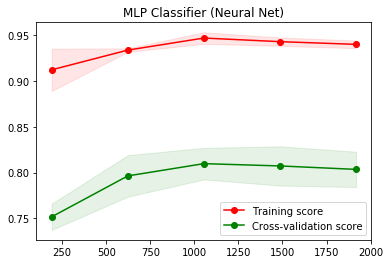

In [37]:
for clf, name in tuned_classifiers:
    study_tuned_classifier(clf, full_name[name])

In [104]:
good_classifiers = [
    tuned_classifiers[0][::-1], #Ridge
    tuned_classifiers[5][::-1], #GD SVM
    tuned_classifiers[6][::-1], #GD Log Regression
    tuned_classifiers[7][::-1], #Log Regression
    tuned_classifiers[10][::-1], #Bernoulli NB
    
]

In [105]:
from sklearn.ensemble import VotingClassifier

In [106]:
voting_clf = VotingClassifier(estimators = good_classifiers)

In [107]:
voting_clf

VotingClassifier(estimators=[('ridgeclf',
                              RidgeClassifier(alpha=0.01, class_weight=None,
                                              copy_X=True, fit_intercept=True,
                                              max_iter=None, normalize=False,
                                              random_state=None, solver='auto',
                                              tol=0.001)),
                             ('gdsvm',
                              SGDClassifier(alpha=0.0005, average=False,
                                            class_weight=None,
                                            early_stopping=False, epsilon=0.1,
                                            eta0=0.0, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='o...
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False

In [109]:
cross_validate_voting_clf(voting_clf, X, y)

0.8130941196938066

## Applying Data to Production Set

In [114]:
stem_lemmatized_df = pd.read_pickle('in_between_files/stem_and_lemmatized_df.pkl')

In [118]:
production_data_df = stem_lemmatized_df[~stem_lemmatized_df["status.id_str"].isin(annotated["status.id_str"])]

In [120]:
production_data_df.columns

Index(['status.full_text', 'status.quoted_status_id_str',
       'status.quoted_status', 'status.entities', 'status.created_at',
       'status.id_str', 'status.in_reply_to_status_id_str',
       'status.in_reply_to_user_id_str', 'status.retweet_count',
       'status.favorite_count', 'status.place', 'status.coordinates',
       'author.id_str', 'author.name', 'author.description', 'author.location',
       'author.verified', 'author.followers_count', 'author.friends_count',
       'author.listed_count', 'author.favourites_count',
       'author.statuses_count', 'replied_text', 'quoted_text', 'headlines',
       'descriptions', 'clean_tweet', 'clean_article', 'clean_tweet_article',
       'clean_tweet_all_texts', 'clean_bio', 'stemmed_all_texts',
       'lemmatized_all_texts', 'lemmatize_stem_all_texts'],
      dtype='object')

In [121]:
production_texts = production_data_df["lemmatize_stem_all_texts"]

In [123]:
A = vectorizer.fit_transform(np.array(production_texts))

In [125]:
best_clf = tuned_classifiers[10][0] #Bernoulli NB
best_clf

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [148]:
pred_probs = best_clf.predict_proba(A)

In [149]:
pred_probs[:10]

array([[0.83864918, 0.16135082],
       [0.8618078 , 0.1381922 ],
       [0.96769547, 0.03230453],
       [0.94679834, 0.05320166],
       [0.70379176, 0.29620824],
       [0.36966966, 0.63033034],
       [0.65098419, 0.34901581],
       [0.99361006, 0.00638994],
       [0.93399932, 0.06600068],
       [0.91613796, 0.08386204]])

In [144]:
threshold = 0.90

In [150]:
pred = [1 if p[1] >= threshold else 0 for p in pred_probs]

In [151]:
production_data_df["Encode"] = pred

In [155]:
effect_to_label = production_data_df[
    production_data_df["Encode"] == 1
    ].sample(2500, random_state = universal_random_state)

In [156]:
effect_to_label.sort_values(by='status.created_at', ignore_index = True, inplace = True)
effect_to_label.reset_index(drop = True, inplace = True)

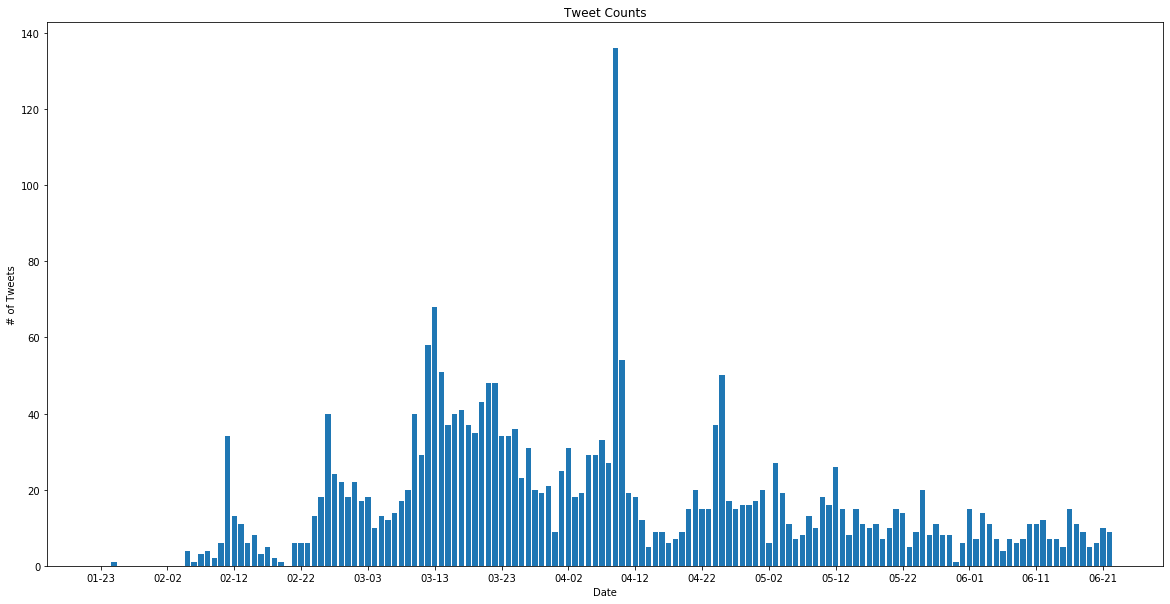

In [157]:
from Script_Processing.study_figures import plot_tweets_over_time
timestamps = effect_to_label["status.created_at"]
timestamps = [stamp.to_pydatetime() for stamp in timestamps]
plot_tweets_over_time(timestamps)

In [163]:
effect_to_label.to_excel("effect_annotations.xlsx")

# Testing

In [38]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, plot_roc_curve, precision_recall_curve, auc 
from sklearn.metrics import plot_confusion_matrix, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt

In [100]:
test_clf = MLPClassifier(hidden_layer_sizes = (1000), activation = 'tanh', max_iter = 500, 
                         solver = 'adam', random_state = universal_random_state) 

In [93]:
vectorizer = TfidfVectorizer(sublinear_tf=True, max_features = 50, max_df=0.15, min_df = 0.01,
                                 stop_words=stop_words_dict["lemma_stem"])

vectorizer = CountVectorizer(max_features = 50, max_df=0.15, min_df = 0.01, stop_words = stop_words_dict["lemma_stem"])

In [94]:
X = vectorizer.fit_transform(np.array(datasets["lemma_stem"]))

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=universal_random_state)

In [101]:
trained_net, net_name = process_classifier(test_clf, "neuralnet", hyper_params)

---------- Processing MLP Classifier (Neural Net) ----------
MLP Classifier (Neural Net) completed in 13.45 seconds. 


accuracy: 0.818 (+/-0.019) for {}
balanced_accuracy: 0.785 (+/-0.016) for {}
average_precision: 0.817 (+/-0.036) for {}
f1_weighted: 0.814 (+/-0.017) for {}
precision: 0.804 (+/-0.092) for {}
recall: 0.665 (+/-0.066) for {}
jaccard: 0.570 (+/-0.027) for {}
roc_auc: 0.865 (+/-0.023) for {}




In [102]:
evaluate_clf_on_heldout_data(trained_net, net_name, X_test, y_test)

---------- Evaluate on held-out data, MLP Classifier (Neural Net) ----------
              precision    recall  f1-score   support

     related       0.83      0.90      0.86       315
   unrelated       0.78      0.64      0.70       165

    accuracy                           0.81       480
   macro avg       0.80      0.77      0.78       480
weighted avg       0.81      0.81      0.81       480



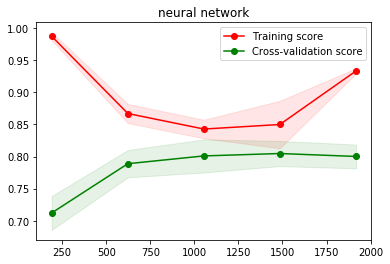

In [103]:
study_tuned_classifier(trained_net, "neural network")

In [44]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)

In [52]:
from sklearn.model_selection import GridSearchCV

In [45]:
gs = GridSearchCV(test_clf, {}, scoring = scoring_metrics, cv = 5, refit = scoring_metrics[1])

In [46]:
what_is_this = gs.fit(X,y)

In [47]:
print(what_is_this)
print(type(what_is_this))

GridSearchCV(cv=5, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=42, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=None, param_grid={},
           

In [55]:
gs.best_estimator_

LinearSVC(C=2, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=5000, multi_class='ovr',
          penalty='l2', random_state=None, tol=0.0005, verbose=0)

In [48]:
def print_metrics(gs, scoring_metrics):
    for metric in scoring_metrics:
        means = gs.cv_results_['mean_test_' + metric]
        stds = gs.cv_results_['std_test_' + metric]
        best_param = gs.best_params_
        for mean, std, params in zip(means, stds, gs.cv_results_['params']):
            if params == best_param:
                print(metric+":","%0.3f (+/-%0.03f) for %r"
                      % (mean, std * 2, params))

In [57]:
gs.best_params_

{'C': 2, 'loss': 'hinge'}

In [58]:
gs.cv_results_['params']

[{'C': 1, 'loss': 'hinge'},
 {'C': 1, 'loss': 'squared_hinge'},
 {'C': 2, 'loss': 'hinge'},
 {'C': 2, 'loss': 'squared_hinge'},
 {'C': 5, 'loss': 'hinge'},
 {'C': 5, 'loss': 'squared_hinge'},
 {'C': 10, 'loss': 'hinge'},
 {'C': 10, 'loss': 'squared_hinge'},
 {'C': 100, 'loss': 'hinge'},
 {'C': 100, 'loss': 'squared_hinge'}]

In [49]:
from sklearn.metrics import classification_report

In [50]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False) #set random_state = 42 for consistency?
skf.get_n_splits(X,y)

5

accuracy: 0.803 (+/-0.046) for {}
balanced_accuracy: 0.779 (+/-0.058) for {}
average_precision: 0.780 (+/-0.076) for {}
f1_weighted: 0.802 (+/-0.048) for {}
precision: 0.742 (+/-0.058) for {}
recall: 0.692 (+/-0.101) for {}
jaccard: 0.559 (+/-0.093) for {}
roc_auc: 0.832 (+/-0.057) for {}
accuracy: 0.817 (+/-0.020) for {}
balanced_accuracy: 0.788 (+/-0.019) for {}
average_precision: 0.808 (+/-0.049) for {}
f1_weighted: 0.814 (+/-0.019) for {}
precision: 0.781 (+/-0.056) for {}
recall: 0.685 (+/-0.041) for {}
jaccard: 0.574 (+/-0.032) for {}
roc_auc: 0.850 (+/-0.039) for {}
accuracy: 0.811 (+/-0.029) for {}
balanced_accuracy: 0.782 (+/-0.034) for {}
average_precision: 0.806 (+/-0.057) for {}
f1_weighted: 0.808 (+/-0.030) for {}
precision: 0.768 (+/-0.054) for {}
recall: 0.680 (+/-0.066) for {}
jaccard: 0.564 (+/-0.057) for {}
roc_auc: 0.846 (+/-0.040) for {}
accuracy: 0.803 (+/-0.045) for {}
balanced_accuracy: 0.776 (+/-0.055) for {}
average_precision: 0.788 (+/-0.073) for {}
f1_weighte

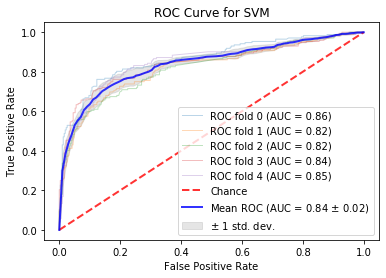

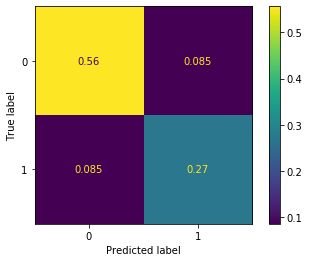

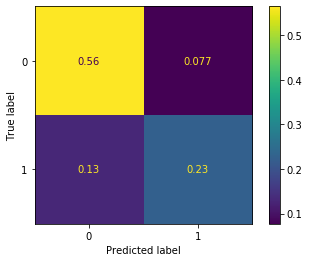

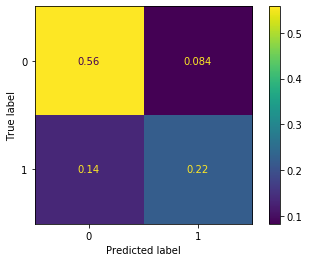

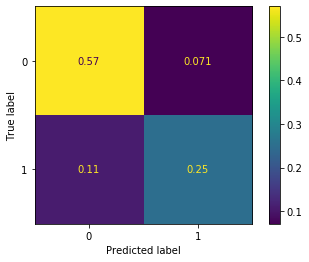

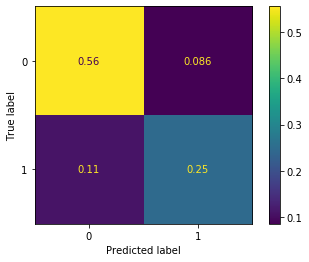

In [51]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train_index, test_index) in enumerate(skf.split(X,y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        fit = gs.fit(X_train,y_train)
        print_metrics(gs, scoring_metrics)
        plot_confusion_matrix(gs, X_test, y_test, normalize = 'all')
        viz = plot_roc_curve(gs, X_test, y_test, name='ROC fold {}'.format(i), alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        #print(y_score)
        
        
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)


mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)


std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC Curve for {}".format("SVM"))
ax.legend(loc="lower right")

plt.show()

In [62]:
from sklearn.model_selection import learning_curve

In [63]:
train_sizes, train_scores, test_scores = learning_curve(LinearSVC(), X, y)

In [64]:
def plot_learning_curve(name, train_sizes, train_scores, test_scores):
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        # Plot learning curve
        plt.title(name)
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1,
                             color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1,
                             color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                     label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                     label="Cross-validation score")
        plt.legend(loc="best")
        
        plt.show()


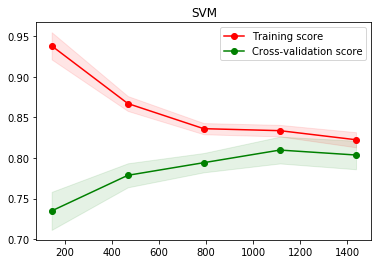

In [65]:
plot_learning_curve("SVM", train_sizes, train_scores, test_scores)

In [66]:
dec_tree = DecisionTreeClassifier(max_depth = 4, random_state = 42)

In [67]:
dec_tree.fit(X,y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [68]:
dec_tree.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.01714404,
       0.        , 0.        , 0.        , 0.01588481, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01995534,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.21737376, 0.11483565, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02207915, 0.        , 0.        , 0.01258322,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.42001742, 0.16012661, 0.        , 0.        , 0.        ])

[Text(683.55, 489.24, 'virus <= 0.5\ngini = 0.45\nsamples = 1798\nvalue = [1184, 614]\nclass = unrelated'),
 Text(418.5, 380.52000000000004, 'hot <= 0.5\ngini = 0.399\nsamples = 1556\nvalue = [1127, 429]\nclass = unrelated'),
 Text(223.2, 271.8, 'warmer <= 0.5\ngini = 0.368\nsamples = 1453\nvalue = [1100, 353]\nclass = unrelated'),
 Text(111.6, 163.08000000000004, 'kill <= 0.5\ngini = 0.339\nsamples = 1376\nvalue = [1079, 297]\nclass = unrelated'),
 Text(55.8, 54.360000000000014, 'gini = 0.316\nsamples = 1327\nvalue = [1066, 261]\nclass = unrelated'),
 Text(167.39999999999998, 54.360000000000014, 'gini = 0.39\nsamples = 49\nvalue = [13, 36]\nclass = related'),
 Text(334.79999999999995, 163.08000000000004, 'stay <= 0.5\ngini = 0.397\nsamples = 77\nvalue = [21, 56]\nclass = related'),
 Text(279.0, 54.360000000000014, 'gini = 0.337\nsamples = 70\nvalue = [15, 55]\nclass = related'),
 Text(390.59999999999997, 54.360000000000014, 'gini = 0.245\nsamples = 7\nvalue = [6, 1]\nclass = unrelated

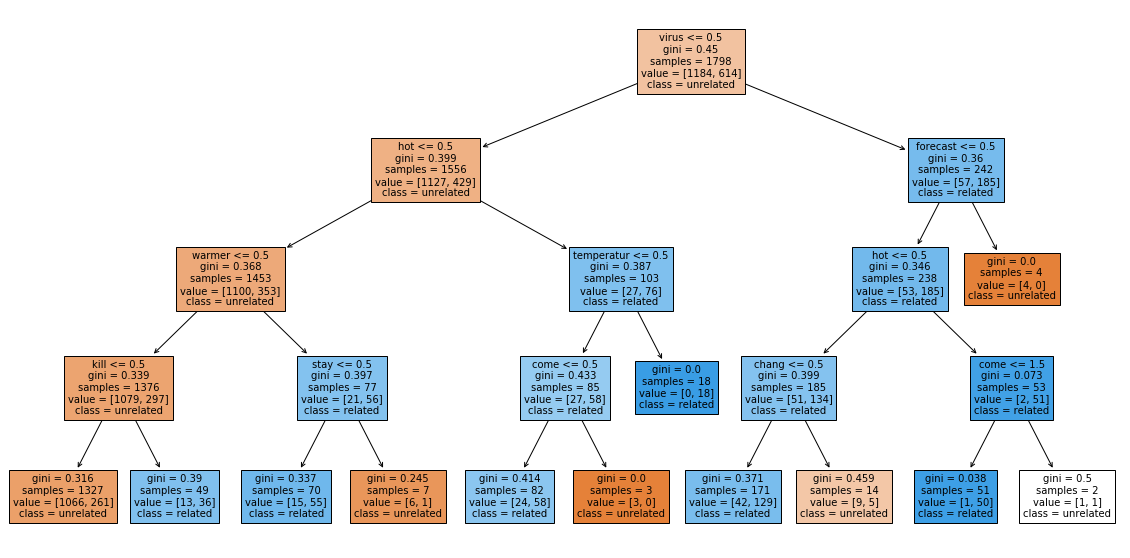

In [69]:
plt.figure(figsize = (20,10))
tree.plot_tree(dec_tree, fontsize=10, 
               feature_names = vectorizer.get_feature_names(), 
               class_names = ["unrelated", "related"],
               filled = True)